## Step 1: Let's get started with SQL

For this project I will be helping a fancy gym run an A/B test!

Currently, when a person is considering buying a membership at this gym, he or she follows the following steps:

Take a fitness test with a personal trainer
Fill out an application for the gym
Send in their payment for their first month’s membership

The manager decided to run an A/B test, thinking that the fitness test intimidates some prospective members.

Visitors were randomly be assigned to one of two groups:

Group A will still be asked to take a fitness test with a personal trainer

Group B will skip the fitness test and proceed directly to the application

Meneger's hypothesis is that visitors assigned to Group B will be more likely to eventually purchase a membership.



I will open and merge all three tables with SQL, which will save them in Pandas DataFrame.

In [197]:
from codecademySQL import sql_query
visits = sql_query('''
SELECT *
FROM visits
LIMIT 5
''')

In [198]:
fitness_tests = sql_query('''
SELECT *
FROM fitness_tests
LIMIT 5
''')


In [199]:
applications = sql_query('''
SELECT *
FROM applications
LIMIT 5
''')


In [200]:
purchases = sql_query('''
SELECT *
FROM purchases
LIMIT 5
''')



Here I'm going to merge the tables using LEFT JOIN 


In [201]:

df = sql_query('''
SELECT 
    visits.first_name,
    visits.last_name,
    visits.gender,
    visits.email,
    visits.visit_date,
    fitness_tests.fitness_test_date,
    applications.application_date,
    purchases.purchase_date
from visits
LEFT JOIN fitness_tests
   ON fitness_tests.first_name = visits.first_name
   AND fitness_tests.last_name = visits.last_name
   AND fitness_tests.email = visits.email
LEFT JOIN applications
   ON applications.first_name = visits.first_name
   AND applications.last_name = visits.last_name
   AND  applications.email = visits.email
LEFT JOIN purchases
   ON purchases.first_name = visits.first_name
   AND purchases.last_name = visits.last_name
   AND  purchases.email = visits.email
where visits.visit_date >= '7-1-17'
   ''')



In [202]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns



Now I can print the merged table with Pandas to analyse 


In [203]:
df.head()

,first_name,last_name,gender,email,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,female,KimWalter58@gmail.com,7-1-17,2017-07-03,None,None
1,Tom,Webster,male,TW3857@gmail.com,7-1-17,2017-07-02,None,None
2,Edward,Bowen,male,Edward.Bowen@gmail.com,7-1-17,None,2017-07-04,2017-07-04
3,Marcus,Bauer,male,Marcus.Bauer@gmail.com,7-1-17,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,female,RB6305@hotmail.com,7-1-17,2017-07-02,None,None



## Step 2: A and B groups investigation

I'm going to create a new column, which will separate all visitors on groups A and B and count them.

In [204]:
df['ab_test_group'] = df.fitness_test_date.apply( lambda x : 'A' if pd.notnull(x) else 'B')

In [205]:
ab_counts = df.groupby('ab_test_group').first_name.count().reset_index()
print(ab_counts)

  ab_test_group  first_name
0             A        2504
1             B        2500


A little visualisation below

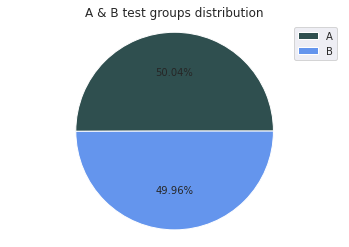

<Figure size 432x288 with 0 Axes>

In [206]:
colors = ['#2F4F4F', '#6495ED']
plt.pie(ab_counts.first_name, autopct = '%0.2f%%' , colors = colors)
plt.axis('equal')
plt.legend(ab_counts.ab_test_group)
plt.title('A & B test groups distribution')
plt.show()
plt.savefig('ab_test_pie_chart.png')

## Step 3: Who picks up an application?



Let's examine how many people make it to Step 2, filling out an application.
I'm going to create a new colomn with the information about visitors who filled out an application and count them.

In [207]:

df['is_application'] = df.application_date.apply(lambda x: 'Application' if pd.notnull(x) else 'No Application')

In [208]:
app_total = df.groupby('is_application').first_name.count().reset_index()
print(app_total)


   is_application  first_name
0     Application         575
1  No Application        4429


From the pie chart below we can see that only 11.49% of all visitors fill out an application.

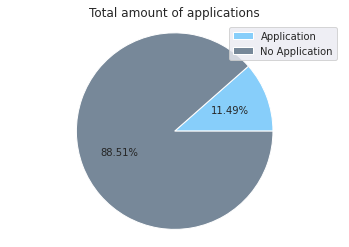

<Figure size 432x288 with 0 Axes>

In [209]:
colors = ['#87CEFA', '#778899']
plt.pie(app_total.first_name, autopct = '%0.2f%%' , colors = colors)
plt.axis('equal')
plt.legend(app_total.is_application)
plt.title('Total amount of applications')
plt.show()
plt.savefig('app_test_pie_chart.png')

Lets's count how many people applied in each group

In [210]:
app_counts = df.groupby(['ab_test_group','is_application']).first_name.count().reset_index()
app_counts

,ab_test_group,is_application,first_name
0,A,Application,250
1,A,No Application,2254
2,B,Application,325
3,B,No Application,2175


In [211]:
app_pivot = app_counts.pivot(columns='is_application',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
app_pivot

is_application,ab_test_group,Application,No Application
0,A,250,2254
1,B,325,2175


In [212]:
app_pivot['Total'] = app_pivot.Application+ app_pivot['No Application']
app_pivot['percentage_applied'] = 100 *app_pivot.Application/app_pivot.Total
app_pivot


is_application,ab_test_group,Application,No Application,Total,percentage_applied
0,A,250,2254,2504,9.984026
1,B,325,2175,2500,13.000000




We need to know if this difference is statistically significant. I'am going to run a Chi Square Test.


In [213]:
from scipy.stats import chi2_contingency

contingency = [[250, 2254], [325, 2175]]
chi2_contingency(contingency)

(10.893961295282612,
 0.0009647827600722304,
 1,
 array([[ 287.72981615, 2216.27018385],
        [ 287.27018385, 2212.72981615]]))

The test showed that the p-value for these two groups = 0.00096, which is less than 0.05. It means that the difference between the amount of those applied for a membership in our groups is significant. 

## Step 4: Who purchases a membership?

Of those who picked up an application, how many purchased a membership?
I'll start by creating a new colomn with those who purchased a membership and follow the same steps as for the previous test. 

In [214]:
df['is_member'] = df.purchase_date.apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

Choosing only the rows with those who applied.

In [215]:
just_apps = df[df.is_application == 'Application']

In [216]:

member_counts = just_apps.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
member_counts


,ab_test_group,is_member,first_name
0,A,Member,200
1,A,Not Member,50
2,B,Member,250
3,B,Not Member,75


In [217]:
member_pivot = member_counts.pivot(columns='is_member',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
member_pivot

is_member,ab_test_group,Member,Not Member
0,A,200,50
1,B,250,75


In [218]:
member_pivot['Total'] = member_pivot.Member+ member_pivot['Not Member']
member_pivot['percentage_purchased'] = 100*member_pivot.Member/member_pivot.Total
member_pivot

is_member,ab_test_group,Member,Not Member,Total,percentage_purchased
0,A,200,50,250,80.000000
1,B,250,75,325,76.923077




Now let's test if the difference in purchase percentage is significant comparing the two groops A and B. (Of those who picked up an application.)

In [219]:
contingency2 = [[200, 50], [250, 75]]
chi2_contingency(contingency2)

(0.615869230769231,
 0.43258646051083327,
 1,
 array([[195.65217391,  54.34782609],
        [254.34782609,  70.65217391]]))

The p-value = 0.43 which is greater than 0.05. It means that the results are not significant. 

Previously, we looked at what percent of people who picked up applications purchased memberships. What we really care about is what percentage of all visitors purchased memberships. I'm going to come back to the DataFrame df and follow the same process that I did in Step 4, including pivoting the data.

In [220]:
final_member__counts = df.groupby(['ab_test_group','is_member']).first_name.count().reset_index()
final_member__counts

,ab_test_group,is_member,first_name
0,A,Member,200
1,A,Not Member,2304
2,B,Member,250
3,B,Not Member,2250


In [221]:
final_pivot = final_member__counts.pivot(columns='is_member',
                                      index='ab_test_group',
                                      values='first_name')\
                                .reset_index()
final_pivot

is_member,ab_test_group,Member,Not Member
0,A,200,2304
1,B,250,2250


In [222]:
final_pivot['Total'] = final_pivot.Member+ final_pivot['Not Member']
final_pivot['percentage_purchased'] = 100*final_pivot.Member/final_pivot.Total
final_pivot

is_member,ab_test_group,Member,Not Member,Total,percentage_purchased
0,A,200,2304,2504,7.98722
1,B,250,2250,2500,10.00000



Let's run a Chi Square Test again to compare the results.

In [223]:
contingency3 = [[200, 2304], [250, 2250]]
chi2_contingency(contingency3)

(5.949182292591156,
 0.014724114645783203,
 1,
 array([[ 225.17985612, 2278.82014388],
        [ 224.82014388, 2275.17985612]]))

The p-value = 0.014 which is less than 0.05. It means that the results are significant and there's a significant difference in number on visitors who purchase a membership between the two groups.

## Step 5. Summarising and Visualisation

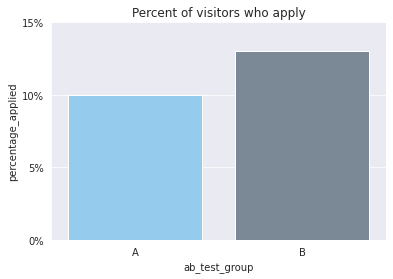

In [224]:
ax = plt.subplot()
colors = ['#87CEFA', '#778899']
sns.set_style('darkgrid')
sns.barplot(data =app_pivot,  x= 'ab_test_group', y ='percentage_applied', palette = colors )
plt.title('Percent of visitors who apply')
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0%', '5%', '10%', '15%'])
plt.show()

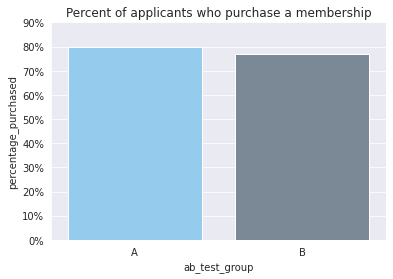

In [225]:
ax = plt.subplot()
sns.set_style('darkgrid')
colors = ['#87CEFA', '#778899']
sns.barplot(data =member_pivot,  x= 'ab_test_group', y ='percentage_purchased', palette = colors)
plt.title('Percent of applicants who purchase a membership')
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.show()

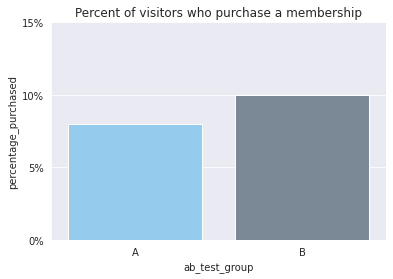

In [226]:
ax = plt.subplot()
sns.set_style('darkgrid')
colors = ['#87CEFA', '#778899']
sns.barplot(data =final_pivot,  x= 'ab_test_group', y ='percentage_purchased', palette = colors)
plt.title('Percent of visitors who purchase a membership')
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0%', '5%', '10%', '15%'])
plt.show()

To sum up, 


5004 visitors were assigned to the groups A and B, 2504 and 2500 respectively.

Only 11.49% of all visitors fill out an application, from which those who don't take a fitness test with a personal trainer are significantly more likely to apply.

Of those who picked up an application, there's no significant difference in purchasing a membership. Applicants of both groups are more likely to make a purchase, around 80%.

However, the test showed that among all visitors, those who take a fitness test are less likely to buy memberships with a significant difference of 2.1%.

The manager's hypothesis that visitors assigned to Group B are more likely to purchase a membership is confirmed.



